# 5 Final assembly

In [4]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from pathlib import Path

NUM_CLASSES = 17
FOLDS = [0, 1, 2, 3, 4]

LABELS_JSON = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\data\labels\track1-qv_pipe_train.json"
SUPER_CSV    = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\data\splits\super_images_3x3_folds.csv"

BASE_RESNET   = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\framewise_resnet18"
BASE_CONVNEXT = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\super_images_convnext"
BASE_TRESNET  = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\super_images_tresnetxl"

# ---------- GT JSON pour tous les modèles ----------
with open(LABELS_JSON, "r") as f:
    gt_dict = json.load(f)

# ---------- CSV super-images : une ligne par vidéo avec labels_str ----------
df_super = pd.read_csv(SUPER_CSV)

# On construit un dict: video_stem (string) -> vecteur multi-hot (17)
super_label_map = {}

for _, row in df_super.iterrows():
    stem = str(row["video_stem"])  # ex: "2019"
    labels_str = str(row["labels_str"])
    if labels_str.strip() == "":
        cls = []
    else:
        cls = [int(x) for x in labels_str.split()]
    vec = np.zeros(NUM_CLASSES, dtype=int)
    for c in cls:
        vec[c] = 1
    super_label_map[stem] = vec


In [5]:
def get_array(data, keys):
    for k in keys:
        if k in data.files:
            return data[k]
    raise KeyError(f"Keys {keys} not found. Found: {data.files}")


def build_y_true_json(video_ids, gt_dict, num_classes=17):
    """Utilise le JSON track1-qv_pipe_train.json"""
    y = np.zeros((len(video_ids), num_classes), dtype=int)
    for i, vid in enumerate(video_ids):
        vid = str(vid)
        # on ramène tout à "<stem>.mp4"
        name = os.path.basename(vid)
        stem, ext = os.path.splitext(name)
        if ext != ".mp4":
            key = stem + ".mp4"
        else:
            key = stem + ext
        for c in gt_dict.get(key, []):
            y[i, c] = 1
    return y


def build_y_true_super_from_csv(raw_ids, label_map, num_classes=17):
    """
    Construit y_true pour les super-images à partir du CSV.
    raw_ids : ce qui est stocké dans le npz (chemins ou id super-image)
    On extrait le video_stem (avant le premier '_') pour matcher le CSV.
    """
    y = np.zeros((len(raw_ids), num_classes), dtype=int)
    for i, s in enumerate(raw_ids):
        s = str(s)
        name = os.path.basename(s)              # "2019_3x3.jpg" ou "2019"
        stem = os.path.splitext(name)[0]        # "2019_3x3" -> "2019_3x3"
        base = stem.split("_")[0]               # "2019"
        vec = label_map.get(base, np.zeros(num_classes, dtype=int))
        y[i] = vec
    return y


def load_preds_framewise(base_dir, model_name, fold):
    path = os.path.join(base_dir, f"preds_{model_name}_fold{fold}.npz")
    data = np.load(path, allow_pickle=True)

    video_ids = get_array(data, ["video_ids", "videos", "ids", "stems"])
    preds     = get_array(data, ["probs", "preds", "logits"])

    if preds.min() < 0 or preds.max() > 1:
        preds = 1 / (1 + np.exp(-preds))

    video_ids = np.array([str(v) for v in video_ids])
    return video_ids, preds.astype(float)


def load_preds_super(base_dir, model_name, fold):
    """
    Charge les prédictions super-images.
    On récupère les IDs bruts (paths ou noms) et on laisse build_y_true_super_from_csv
    s'occuper de retrouver le bon video_stem.
    """
    path = os.path.join(base_dir, f"preds_{model_name}_fold{fold}.npz")
    data = np.load(path, allow_pickle=True)

    raw_ids = get_array(data, ["superimage_paths", "paths", "image_paths",
                               "video_ids", "videos", "ids"])
    preds   = get_array(data, ["probs", "preds", "logits"])

    if preds.min() < 0 or preds.max() > 1:
        preds = 1 / (1 + np.exp(-preds))

    raw_ids = np.array([str(v) for v in raw_ids])
    return raw_ids, preds.astype(float)


In [6]:
def compute_ap_per_class_framewise():
    all_probs = []
    all_ytrue = []

    for fold in FOLDS:
        vids, probs = load_preds_framewise(BASE_RESNET, "resnet18", fold)
        y_true = build_y_true_json(vids, gt_dict, NUM_CLASSES)
        all_probs.append(probs)
        all_ytrue.append(y_true)

    all_probs = np.vstack(all_probs)
    all_ytrue = np.vstack(all_ytrue)
    return average_precision_score(all_ytrue, all_probs, average=None)


def compute_ap_per_class_super(base_dir, model_name):
    all_probs = []
    all_ytrue = []

    for fold in FOLDS:
        raw_ids, probs = load_preds_super(base_dir, model_name, fold)
        y_true = build_y_true_super_from_csv(raw_ids, super_label_map, NUM_CLASSES)
        all_probs.append(probs)
        all_ytrue.append(y_true)

    all_probs = np.vstack(all_probs)
    all_ytrue = np.vstack(all_ytrue)
    return average_precision_score(all_ytrue, all_probs, average=None)


print("Calcul AP par modèle...")

ap_resnet   = compute_ap_per_class_framewise()
ap_convnext = compute_ap_per_class_super(BASE_CONVNEXT, "convnext")
ap_tresnet  = compute_ap_per_class_super(BASE_TRESNET,  "tresnetxl")

print("mAP ResNet18      :", ap_resnet.mean())
print("mAP ConvNeXt      :", ap_convnext.mean())
print("mAP TResNet-XL    :", ap_tresnet.mean())


Calcul AP par modèle...
mAP ResNet18      : 0.45327347514910454
mAP ConvNeXt      : 0.4771496719237853
mAP TResNet-XL    : 0.482871596256143


In [7]:
def compute_ap_per_class_ensemble():
    all_p_ens = []
    all_ytrue = []

    for fold in FOLDS:
        # Framewise
        vids_r, p_r = load_preds_framewise(BASE_RESNET, "resnet18", fold)
        y_r = build_y_true_json(vids_r, gt_dict, NUM_CLASSES)

        # Super-images (ConvNeXt)
        ids_c_raw, p_c = load_preds_super(BASE_CONVNEXT, "convnext", fold)
        y_c = build_y_true_super_from_csv(ids_c_raw, super_label_map, NUM_CLASSES)

        # Super-images (TResNet-XL)
        ids_t_raw, p_t = load_preds_super(BASE_TRESNET, "tresnetxl", fold)
        y_t = build_y_true_super_from_csv(ids_t_raw, super_label_map, NUM_CLASSES)

        # Canonicaliser les IDs niveau vidéo pour l'intersection
        def to_stem_list(raw_ids):
            stems = []
            for s in raw_ids:
                s = str(s)
                name = os.path.basename(s)
                stem = os.path.splitext(name)[0]
                base = stem.split("_")[0]
                stems.append(base)
            return np.array(stems)

        stems_r = to_stem_list(vids_r)       # ex: "2019"
        stems_c = to_stem_list(ids_c_raw)
        stems_t = to_stem_list(ids_t_raw)

        common = sorted(set(stems_r) & set(stems_c) & set(stems_t))
        if not common:
            continue

        idx_r = [np.where(stems_r == s)[0][0] for s in common]
        idx_c = [np.where(stems_c == s)[0][0] for s in common]
        idx_t = [np.where(stems_t == s)[0][0] for s in common]

        p_r2 = p_r[idx_r]
        p_c2 = p_c[idx_c]
        p_t2 = p_t[idx_t]

        # Les y_true sont identiques pour r/c/t, on peut en prendre un :
        y_true_fold = y_r[idx_r]

        p_ens = (p_r2 + p_c2 + p_t2) / 3.0

        all_p_ens.append(p_ens)
        all_ytrue.append(y_true_fold)

    all_p_ens = np.vstack(all_p_ens)
    all_ytrue = np.vstack(all_ytrue)

    return average_precision_score(all_ytrue, all_p_ens, average=None)


print("Calcul AP ensemble...")
ap_ensemble = compute_ap_per_class_ensemble()
print("mAP ensemble :", ap_ensemble.mean())

# ---------- DataFrame + CSV ----------
df_ap_methods = pd.DataFrame({
    "framewise_resnet18": ap_resnet,
    "superimg_convnext": ap_convnext,
    "superimg_tresnetxl": ap_tresnet,
    "ensemble_3models": ap_ensemble,
})
df_ap_methods.index = [f"class_{i:02d}" for i in range(NUM_CLASSES)]

display(df_ap_methods)

csv_path = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\ap_per_class_all_models.csv"
df_ap_methods.to_csv(csv_path, index=True)

print("\nCSV sauvé à :")
print(csv_path)


Calcul AP ensemble...
mAP ensemble : 0.5879619389116456


,framewise_resnet18,superimg_convnext,superimg_tresnetxl,ensemble_3models
class_00,0.889423,0.905787,0.993349,0.980938
class_01,0.692712,0.721686,0.700285,0.763816
class_02,0.449628,0.516644,0.570932,0.585193
class_03,0.438228,0.531618,0.507523,0.579385
class_04,0.657758,0.772814,0.788937,0.827422
class_05,0.651704,0.822009,0.847419,0.864190
class_06,0.336716,0.395509,0.414002,0.520358
class_07,0.632346,0.638583,0.594738,0.757557
class_08,0.436289,0.572388,0.503486,0.612676
class_09,0.459173,0.459566,0.475573,0.546233



CSV sauvé à :
C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\ap_per_class_all_models.csv


In [8]:
def compute_ap_per_class_ensemble():
    all_p_ens = []
    all_ytrue = []

    for fold in FOLDS:
        # Framewise
        vids_r, p_r = load_preds_framewise(BASE_RESNET, "resnet18", fold)
        y_r = build_y_true_json(vids_r, gt_dict, NUM_CLASSES)

        # Super-images (ConvNeXt)
        ids_c_raw, p_c = load_preds_super(BASE_CONVNEXT, "convnext", fold)
        y_c = build_y_true_super_from_csv(ids_c_raw, super_label_map, NUM_CLASSES)

        # Super-images (TResNet-XL)
        ids_t_raw, p_t = load_preds_super(BASE_TRESNET, "tresnetxl", fold)
        y_t = build_y_true_super_from_csv(ids_t_raw, super_label_map, NUM_CLASSES)

        # Canonicaliser les IDs niveau vidéo pour l'intersection
        def to_stem_list(raw_ids):
            stems = []
            for s in raw_ids:
                s = str(s)
                name = os.path.basename(s)
                stem = os.path.splitext(name)[0]
                base = stem.split("_")[0]
                stems.append(base)
            return np.array(stems)

        stems_r = to_stem_list(vids_r)       # ex: "2019"
        stems_c = to_stem_list(ids_c_raw)
        stems_t = to_stem_list(ids_t_raw)

        common = sorted(set(stems_r) & set(stems_c) & set(stems_t))
        if not common:
            continue

        idx_r = [np.where(stems_r == s)[0][0] for s in common]
        idx_c = [np.where(stems_c == s)[0][0] for s in common]
        idx_t = [np.where(stems_t == s)[0][0] for s in common]

        p_r2 = p_r[idx_r]
        p_c2 = p_c[idx_c]
        p_t2 = p_t[idx_t]

        # Les y_true sont identiques pour r/c/t, on peut en prendre un :
        y_true_fold = y_r[idx_r]

        p_ens = (p_r2 + p_c2 + p_t2) / 3.0

        all_p_ens.append(p_ens)
        all_ytrue.append(y_true_fold)

    all_p_ens = np.vstack(all_p_ens)
    all_ytrue = np.vstack(all_ytrue)

    return average_precision_score(all_ytrue, all_p_ens, average=None)


print("Calcul AP ensemble...")
ap_ensemble = compute_ap_per_class_ensemble()
print("mAP ensemble :", ap_ensemble.mean())

# ---------- DataFrame + CSV ----------
df_ap_methods = pd.DataFrame({
    "framewise_resnet18": ap_resnet,
    "superimg_convnext": ap_convnext,
    "superimg_tresnetxl": ap_tresnet,
    "ensemble_3models": ap_ensemble,
})
df_ap_methods.index = [f"class_{i:02d}" for i in range(NUM_CLASSES)]

display(df_ap_methods)

csv_path = r"C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\ap_per_class_all_models.csv"
df_ap_methods.to_csv(csv_path, index=True)

print("\nCSV sauvé à :")
print(csv_path)


Calcul AP ensemble...
mAP ensemble : 0.5879619389116456


,framewise_resnet18,superimg_convnext,superimg_tresnetxl,ensemble_3models
class_00,0.889423,0.905787,0.993349,0.980938
class_01,0.692712,0.721686,0.700285,0.763816
class_02,0.449628,0.516644,0.570932,0.585193
class_03,0.438228,0.531618,0.507523,0.579385
class_04,0.657758,0.772814,0.788937,0.827422
class_05,0.651704,0.822009,0.847419,0.864190
class_06,0.336716,0.395509,0.414002,0.520358
class_07,0.632346,0.638583,0.594738,0.757557
class_08,0.436289,0.572388,0.503486,0.612676
class_09,0.459173,0.459566,0.475573,0.546233



CSV sauvé à :
C:\Users\Simon VANDERCOILDEN\Desktop\Scolaire\UTC\IM05\TX01\qv-pipe-classifier\exp\results\ap_per_class_all_models.csv


Macro vs micro (très vite)

mAP macro :

tu calcules l’AP pour chaque classe

puis tu fais la moyenne non pondérée

→ toutes les classes comptent pareil (même les rares)

mAP micro :

tu considères tous les couples (échantillon, classe) d’un coup

tu aplatit tout et tu fais un seul average_precision_score avec average="micro"

→ les classes fréquentes pèsent plus lourd

plus proche d’une “performance globale sur tous les labels”

Dans un rapport, c’est top de donner macro + micro et de dire que le challenge (QV-Pipe, en général) utilise la macro.

In [9]:
import os
import numpy as np
from sklearn.metrics import average_precision_score

NUM_CLASSES = 17
FOLDS = [0, 1, 2, 3, 4]

# -------------------------------------------------------------------
# Fonctions utilitaires si tu ne les as plus
# -------------------------------------------------------------------
def get_array(data, keys):
    for k in keys:
        if k in data.files:
            return data[k]
    raise KeyError(f"Keys {keys} not found. Found: {data.files}")

def build_y_true_json(video_ids, gt_dict, num_classes=17):
    y = np.zeros((len(video_ids), num_classes), dtype=int)
    for i, vid in enumerate(video_ids):
        vid = str(vid)
        name = os.path.basename(vid)
        stem, ext = os.path.splitext(name)
        if ext != ".mp4":
            key = stem + ".mp4"
        else:
            key = stem + ext
        for c in gt_dict.get(key, []):
            y[i, c] = 1
    return y

def build_y_true_super_from_csv(raw_ids, label_map, num_classes=17):
    y = np.zeros((len(raw_ids), num_classes), dtype=int)
    for i, s in enumerate(raw_ids):
        s = str(s)
        name = os.path.basename(s)
        stem = os.path.splitext(name)[0]
        base = stem.split("_")[0]
        vec = label_map.get(base, np.zeros(num_classes, dtype=int))
        y[i] = vec
    return y

def load_preds_framewise(base_dir, model_name, fold):
    path = os.path.join(base_dir, f"preds_{model_name}_fold{fold}.npz")
    data = np.load(path, allow_pickle=True)
    video_ids = get_array(data, ["video_ids", "videos", "ids", "stems"])
    preds     = get_array(data, ["probs", "preds", "logits"])
    if preds.min() < 0 or preds.max() > 1:
        preds = 1 / (1 + np.exp(-preds))
    video_ids = np.array([str(v) for v in video_ids])
    return video_ids, preds.astype(float)

def load_preds_super(base_dir, model_name, fold):
    path = os.path.join(base_dir, f"preds_{model_name}_fold{fold}.npz")
    data = np.load(path, allow_pickle=True)
    raw_ids = get_array(data, ["superimage_paths", "paths", "image_paths",
                               "video_ids", "videos", "ids"])
    preds   = get_array(data, ["probs", "preds", "logits"])
    if preds.min() < 0 or preds.max() > 1:
        preds = 1 / (1 + np.exp(-preds))
    raw_ids = np.array([str(v) for v in raw_ids])
    return raw_ids, preds.astype(float)


In [10]:
def map_micro_framewise():
    all_probs = []
    all_ytrue = []

    for fold in FOLDS:
        vids, probs = load_preds_framewise(BASE_RESNET, "resnet18", fold)
        y_true = build_y_true_json(vids, gt_dict, NUM_CLASSES)
        all_probs.append(probs)
        all_ytrue.append(y_true)

    all_probs = np.vstack(all_probs)
    all_ytrue = np.vstack(all_ytrue)

    return average_precision_score(all_ytrue, all_probs, average="micro")

map_micro_resnet = map_micro_framewise()
print("mAP micro ResNet18 :", map_micro_resnet)


mAP micro ResNet18 : 0.5856499502552677


In [11]:
def map_micro_super(base_dir, model_name):
    all_probs = []
    all_ytrue = []

    for fold in FOLDS:
        raw_ids, probs = load_preds_super(base_dir, model_name, fold)
        y_true = build_y_true_super_from_csv(raw_ids, super_label_map, NUM_CLASSES)
        all_probs.append(probs)
        all_ytrue.append(y_true)

    all_probs = np.vstack(all_probs)
    all_ytrue = np.vstack(all_ytrue)
    return average_precision_score(all_ytrue, all_probs, average="micro")

map_micro_convnext = map_micro_super(BASE_CONVNEXT, "convnext")
map_micro_tresnet  = map_micro_super(BASE_TRESNET,  "tresnetxl")

print("mAP micro ConvNeXt   :", map_micro_convnext)
print("mAP micro TResNet-XL :", map_micro_tresnet)


mAP micro ConvNeXt   : 0.6301469162282365
mAP micro TResNet-XL : 0.6599549723644266


In [13]:
import pandas as pd

# Vérifie nom des colonnes
df_ap_methods.columns


Index(['framewise_resnet18', 'superimg_convnext', 'superimg_tresnetxl',
       'ensemble_3models'],
      dtype='object')

In [14]:
import numpy as np
import pandas as pd

# Colonnes des modèles individuels
cols_single = ["framewise_resnet18", "superimg_convnext", "superimg_tresnetxl"]

# Meilleur modèle seul par classe
best_single = df_ap_methods[cols_single].max(axis=1)

# Nouveau DataFrame pour scatter + CSV
df_scatter = pd.DataFrame({
    "class_name": df_ap_methods.index,
    "class_id": [int(name.split("_")[1]) for name in df_ap_methods.index],
    "best_single_AP": best_single.values,
    "ensemble_AP": df_ap_methods["ensemble_3models"].values,
})

# Gain de l'ensemble par classe
df_scatter["gain_ensemble"] = df_scatter["ensemble_AP"] - df_scatter["best_single_AP"]

df_scatter


,class_name,class_id,best_single_AP,ensemble_AP,gain_ensemble
0,class_00,0,0.993349,0.980938,-0.012411
1,class_01,1,0.721686,0.763816,0.042130
2,class_02,2,0.570932,0.585193,0.014261
3,class_03,3,0.531618,0.579385,0.047766
4,class_04,4,0.788937,0.827422,0.038485
5,class_05,5,0.847419,0.864190,0.016771
6,class_06,6,0.414002,0.520358,0.106357
7,class_07,7,0.638583,0.757557,0.118974
8,class_08,8,0.572388,0.612676,0.040287
9,class_09,9,0.475573,0.546233,0.070660


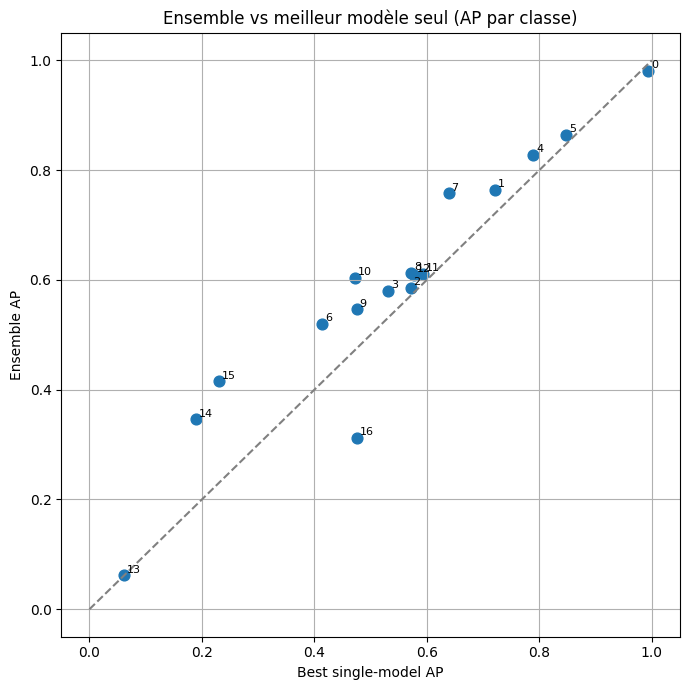

In [17]:
import matplotlib.pyplot as plt

x = df_scatter["best_single_AP"].values
y = df_scatter["ensemble_AP"].values

plt.figure(figsize=(7, 7))
plt.scatter(x, y, s=60)

# Diagonale y = x
plt.plot([0, 1], [0, 1], "--", color="gray")

# Labels des points (numéros de classes)
for _, row in df_scatter.iterrows():
    cid = row["class_id"]
    plt.text(row["best_single_AP"] + 0.005,
             row["ensemble_AP"] + 0.005,
             str(cid),
             fontsize=8)

plt.xlabel("Best single-model AP")
plt.ylabel("Ensemble AP")
plt.title("Ensemble vs meilleur modèle seul (AP par classe)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd

# Colonnes des modèles individuels
cols_single = ["framewise_resnet18", "superimg_convnext", "superimg_tresnetxl"]

# Meilleur modèle seul par classe
best_single = df_ap_methods[cols_single].max(axis=1)

# Construction du DataFrame scatter
df_scatter = pd.DataFrame({
    "class_name": df_ap_methods.index,
    "class_id": [int(name.split("_")[1]) for name in df_ap_methods.index],
    "best_single_AP": best_single.values,
    "ensemble_AP": df_ap_methods["ensemble_3models"].values,
})

# Gain apporté par l'ensemble
df_scatter["gain_ensemble"] = df_scatter["ensemble_AP"] - df_scatter["best_single_AP"]

# Affichage complet
df_scatter



,class_name,class_id,best_single_AP,ensemble_AP,gain_ensemble
0,class_00,0,0.993349,0.980938,-0.012411
1,class_01,1,0.721686,0.763816,0.042130
2,class_02,2,0.570932,0.585193,0.014261
3,class_03,3,0.531618,0.579385,0.047766
4,class_04,4,0.788937,0.827422,0.038485
5,class_05,5,0.847419,0.864190,0.016771
6,class_06,6,0.414002,0.520358,0.106357
7,class_07,7,0.638583,0.757557,0.118974
8,class_08,8,0.572388,0.612676,0.040287
9,class_09,9,0.475573,0.546233,0.070660
